# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 18.1MB/s 


# Evn

In [ ]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [ ]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
!nvidia-smi

Mon Feb  1 03:51:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
data_dir = '/content/drive/MyDrive/data/data'
os.listdir(data_dir)

['ko_32000.model',
 'ko_32000.vocab',
 'kowiki',
 'mycorpus',
 '.ipynb_checkpoints',
 'my_vocab.model',
 'nsmc',
 'quora']

In [ ]:
# quora dir
quora_dir = os.path.join(data_dir, 'quora')
if not os.path.exists(quora_dir):
    os.makedirs(quora_dir)
os.listdir(quora_dir)

['kor_pair_train.csv', 'kor_Pair_test.csv', 'stub.csv', 'stub.hdf5']

# Vocabulary & config

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [ ]:
n_vocab = len(vocab)  # number of vocabulary
n_seq_1 = 26  # number of sequence 1
n_seq_2 = 27  # number of sequence 2
d_model = 256  # dimension of model
n_out = 2  # number of output class

# 모델링

In [ ]:
def build_model(n_vocab, d_model, n_seq_1, n_seq_2):
    """
    문장 유사도 비교 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq_1: 문장 1 길이 (단어 수)
    :param n_seq_2: 문장 2 길이 (단어 수)
    """
    inputs_1 = tf.keras.layers.Input((n_seq_1,))  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((n_seq_2,))  # (bs, n_seq_2)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)

    #RNN / CNN
    rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True))
    hidden_1 = rnn_1(hidden_1)
    #rnn_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=128, return_sequences=True))
    #hidden_1 = rnn_2(hidden_1)
    #rnn_3 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=128, return_sequences=True))
    #hidden_1 = rnn_3(hidden_1)
    cnn_1 = tf.keras.layers.Conv1D(filters=d_model, kernel_size=5, padding='same')
    hidden_1 = cnn_1(hidden_1)


    hidden_2 = rnn_1(hidden_2)
    #hidden_2 = rnn_2(hidden_2)
    #hidden_2 = rnn_3(hidden_2)
    hidden_2 = cnn_1(hidden_2)


    # 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool_1 = pool(hidden_1)  # (bs, d_model)
    hidden_pool_2 = pool(hidden_2)  # (bs, d_model)
    # distance 계산 ||a - b||
    distance = K.sum(K.abs(hidden_pool_1 - hidden_pool_2), axis=-1)
    outputs = K.exp(-distance)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=outputs)
    return model

# All Data Project

## Data


In [ ]:
df_train = pd.read_csv(os.path.join(quora_dir, 'kor_pair_train.csv'), delimiter=',')
df_train

In [ ]:
df_train = df_train.dropna()
df_train

In [ ]:
df_test = pd.read_csv(os.path.join(quora_dir, 'kor_Pair_test.csv'), delimiter=',')
df_test

In [ ]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

In [ ]:
df_test = df_test.dropna()
df_test

In [ ]:
def load_data(df, n_seq_1, n_seq_2):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_seq_1: number of sequence 1
    :param n_seq_2: number of sequence 2
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    inputs_1 = np.zeros((len(df), n_seq_1)).astype(np.int32)
    inputs_2 = np.zeros((len(df), n_seq_2)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        is_duplicate = row['is_duplicate']
        question1 = row['question1']
        question2 = row['question2']

        tokens_1 = vocab.encode_as_pieces(question1)
        tokens_2 = vocab.encode_as_pieces(question2)

        token_ids_1 = vocab.encode_as_ids(question1)
        token_ids_2 = vocab.encode_as_ids(question2)

        token_ids_1 = token_ids_1[:n_seq_1]
        token_ids_2 = token_ids_2[:n_seq_2]

        token_ids_1 += [0] * (n_seq_1 - len(token_ids_1))
        token_ids_2 += [0] * (n_seq_2 - len(token_ids_2))

        labels[index] = 1 - is_duplicate  # 0 -> 1, 1 -> 0
        inputs_1[index] = token_ids_1
        inputs_2[index] = token_ids_2
        index += 1
    return inputs_1, inputs_2, labels

In [ ]:
# train data 생성
train_inputs_1, train_inputs_2, train_labels = load_data(df_train, n_seq_1, n_seq_2)
train_inputs_1, train_inputs_2, train_labels

In [ ]:
# test data 생성
test_inputs_1, test_inputs_2, test_labels = load_data(df_test, n_seq_1, n_seq_2)
test_inputs_1, test_inputs_2, test_labels

## 학습

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq_1, n_seq_2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(quora_dir, 'stub.hdf5'),
                                                  monitor='val_binary_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(quora_dir, 'stub.csv'))

In [ ]:
# 모델 학습
history = model.fit((train_inputs_1, train_inputs_2),
                    train_labels,
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
27/27 [==============================] - 9s 176ms/step - loss: 0.1582 - binary_accuracy: 0.7766 - val_loss: 0.2405 - val_binary_accuracy: 0.5805

Epoch 00001: val_binary_accuracy improved from -inf to 0.58049, saving model to /content/drive/MyDrive/data/data/quora/stub.hdf5
Epoch 2/100
27/27 [==============================] - 3s 116ms/step - loss: 0.0932 - binary_accuracy: 0.8983 - val_loss: 0.2415 - val_binary_accuracy: 0.6100

Epoch 00002: val_binary_accuracy improved from 0.58049 to 0.60997, saving model to /content/drive/MyDrive/data/data/quora/stub.hdf5
Epoch 3/100
27/27 [==============================] - 3s 119ms/step - loss: 0.0561 - binary_accuracy: 0.9530 - val_loss: 0.2394 - val_binary_accuracy: 0.6183

Epoch 00003: val_binary_accuracy improved from 0.60997 to 0.61825, saving model to /content/drive/MyDrive/data/data/quora/stub.hdf5
Epoch 4/100
27/27 [==============================] - 3s 115ms/step - loss: 0.0373 - binary_accuracy: 0.9755 - val_loss: 0.2422 - val_

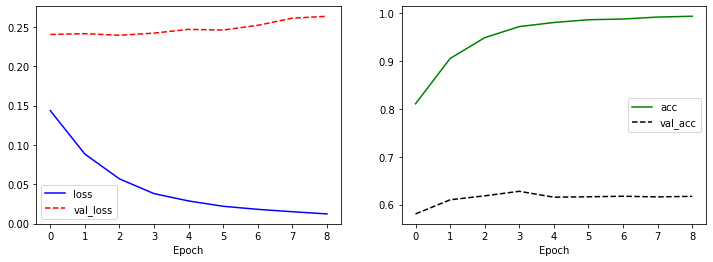

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], 'g-', label='acc')
plt.plot(history.history['val_binary_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq_1, n_seq_2)
# train weight로 초기화
model.load_weights(os.path.join(quora_dir, 'stub.hdf5'))

In [ ]:
# 예측
logits = model.predict((test_inputs_1, test_inputs_2))
logits

In [ ]:
# 0.5를 기준으로 (0, 1) 결정
test_preds = (0.5 < logits).astype(np.int)
test_preds

In [ ]:
# confusion matrix 계산
confusion_matrix = np.zeros((2, 2)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

array([[133, 196],
       [ 64, 295]])

In [ ]:
# score 계산
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max(tp + tn + fp + fn, 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max(tp + fp, 1)
print(f'precision: {precision}')
recall = (tp) / max(tp + fn, 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max(precision + recall, 1)
print(f'f1: {f1}')

accuracy: 0.622093023255814
precision: 0.6008146639511202
recall: 0.8217270194986073
f1: 0.6941176470588236


In [ ]:
def do_predict(model, n_seq_1, string1, n_seq_2, string2):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq_1: 입력 개수 1
    :param string1: 입력 문자열 1
    :param n_seq_1: 입력 개수 3
    :param string2: 입력 문자열 2
    """
    # token 생성: <string 1 tokens>, [PAD] tokens
    token1 = vocab.encode_as_ids(string1)[:n_seq_1]
    token1 += [0] * (n_seq_1 - len(token1))

    # token 생성: <string 2 tokens>, [PAD] tokens
    token2 = vocab.encode_as_ids(string2)[:n_seq_2]
    token2 += [0] * (n_seq_2 - len(token2))

    y_pred = model.predict((np.array([token1]), np.array([token2])))

    return "같음" if y_pred[0] > 0.5 else "다름"

In [ ]:
while True:
    print("string #1 > ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("string #2 > ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    print(f"output > {do_predict(model, n_seq_1, string1, n_seq_2, string2)}")

string #1 > 당신은 천재입니까?
string #2 > 와 정말 똑똑하다
output > 다름
string #1 > 정말 똑똑하네요
string #2 > 정말 명석하네요
output > 다름
string #1 > 
